In [1]:
import glob
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import pandas as pd
import matplotlib.pyplot as plt
import sys,os

In [2]:
# Conveniently list available tracks to analyze
available_track_files = glob.glob("../Tracks/**.npy")
available_track_names = list(map(lambda x: os.path.basename(x).split('.npy')[0], available_track_files))
available_track_names

['Albert',
 'cumulo_turnpike',
 'reInvent2019',
 'reinvent_base',
 'Spain_track',
 'stratus']

In [4]:
WAYPOINT_FILE_NAME = 'stratus_waypoints'
sys.path.append(os.path.abspath('../Tracks'))
# import WAYPOINT_FILE_NAME as wp
exec('import *'%WAYPOINT_FILE_NAME)


In [5]:
wp.waypoints

NameError: name 'wp' is not defined

In [9]:
def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '.', color='#999999', zorder=1)                               
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='#000000', zorder=1)                               
                                                                                
def plot_line(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                                                                                
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)                                                
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)
    
    line = LineString(outer_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line) 

In [10]:
waypoints = [(5.691117525100708, -3.4853140115737915), (5.540876150131226, -3.4840049743652344), (5.390634536743164, -3.4826955795288086), (5.240392446517944, -3.4813843965530396), (5.090150833129883, -3.480072498321533), (4.9399094581604, -3.478758454322815), (4.78966760635376, -3.4774433374404907), (4.6394264698028564, -3.4761266708374023), (4.489184379577637, -3.4748083353042603), (4.338942527770996, -3.4734894037246704), (4.188701391220093, -3.472169518470764), (4.038459539413452, -3.4708566665649414), (3.88821804523468, -3.4695510864257812), (3.7379759550094604, -3.468254566192627), (3.5877349376678467, -3.4669665098190308), (3.4374929666519165, -3.465686082839966), (3.2872509956359863, -3.4644140005111694), (3.137009024620056, -3.4631495475769043), (2.986767053604126, -3.4618935585021973), (2.836525559425354, -3.460613965988159), (2.686283588409424, -3.4592854976654053), (2.53604257106781, -3.457908511161804), (2.3858014345169045, -3.4564836025238037), (2.235560417175293, -3.4550105333328247), (2.0853199958801247, -3.4534884691238403), (1.9350790381431568, -3.4519180059432983), (1.7848390340805032, -3.4503015279769897), (1.6345980167388903, -3.4488364458084106), (1.4843560457229614, -3.447663426399231), (1.334112524986267, -3.446780562400818), (1.1838675141334534, -3.4461899995803833), (1.0336215496063232, -3.4458905458450317), (0.8833742141723633, -3.4458824396133423), (0.7331256568431854, -3.446165919303894), (0.582878589630127, -3.4460949897766113), (0.4326391965150833, -3.444275975227356), (0.2824075520038605, -3.4406614303588867), (0.13218370452523232, -3.435250997543335), (-0.017458884045481682, -3.4226540327072144), (-0.16453809943050146, -3.3918925523757935), (-0.30591633915901184, -3.3411219120025635), (-0.4369644522666931, -3.267691969871521), (-0.5519265383481979, -3.171091914176941), (-0.6456878259778023, -3.0538324117660522), (-0.7156317755579948, -2.920941948890686), (-0.7622010409832001, -2.7781230211257935), (-0.7879758477210999, -2.630092978477478), (-0.7957301884889603, -2.4800760746002197), (-0.7897157818078995, -2.4033600091934204), (-0.7965705394744873, -2.273432493209839), (-0.912798672914505, -2.044341564178467), (-1.0588050186634064, -1.946749985218048), (-1.1529135704040527, -1.908869981765747), (-1.2701885104179382, -1.8645615577697754), (-1.4115034937858582, -1.813528060913086), (-1.5528219938278198, -1.762504518032074), (-1.6941199898719788, -1.7114259600639343), (-1.8353834748268127, -1.6602495312690735), (-1.9765940308570862, -1.608928918838501), (-2.117736518383026, -1.557420551776886), (-2.2587890625, -1.505668044090271), (-2.399764060974121, -1.453702598810196), (-2.5404860973358154, -1.4010591804981232), (-2.6831225156784058, -1.3539236187934875), (-2.830204963684082, -1.3234391808509827), (-2.980054020881653, -1.3139451742172241), (-3.129472017288208, -1.3287698328495026), (-3.274051070213318, -1.36915123462677), (-3.4097719192504883, -1.4334065318107605), (-3.534134030342102, -1.5175745487213135), (-3.646527409553528, -1.6172325015068054), (-3.75149142742157, -1.7247360348701477), (-3.85636305809021, -1.8323294520378113), (-3.961322069168091, -1.9398369789123535), (-4.066370129585267, -2.0472574830055246), (-4.171505093574524, -2.1545934677124023), (-4.27676248550415, -2.2618085741996765), (-4.382499933242798, -2.368552565574646), (-4.496072053909302, -2.466829538345337), (-4.622316360473633, -2.5481845140457153), (-4.759808540344238, -2.608499050140381), (-4.905761480331421, -2.64373242855072), (-5.055671691894531, -2.6514259576797485), (-5.204542875289917, -2.6317930221557617), (-5.348028659820557, -2.587536573410034), (-5.4831788539886475, -2.522094488143921), (-5.61224102973938, -2.4451170563697815), (-5.738352537155151, -2.3633905053138733), (-5.862893581390381, -2.2792704701423645), (-5.986413478851318, -2.193693995475769), (-6.108869552612305, -2.1066089868545532), (-6.22988748550415, -2.0175780653953552), (-6.349385976791382, -1.9265029430389404), (-6.467352390289307, -1.8334065079689026), (-6.583738088607788, -1.7383804321289062), (-6.698537349700928, -1.64143306016922), (-6.811707019805908, -1.5425724983215332), (-6.923160076141357, -1.4418140053749084), (-7.032895565032959, -1.3391582071781158), (-7.140852451324463, -1.2346395552158356), (-7.246981859207153, -1.1282867789268494), (-7.351280450820923, -1.0201025307178493), (-7.4536778926849365, -0.9101418554782867), (-7.554150342941284, -0.7984253168106079), (-7.652686357498169, -0.6849650293588638), (-7.749224901199341, -0.5698329955339432), (-7.843758583068848, -0.45303990319371223), (-7.936265707015991, -0.3346173167228699), (-8.026707410812378, -0.21463950350880623), (-8.115080833435059, -0.09310939908027649), (-8.201364517211914, 0.029913991689682007), (-8.285537958145142, 0.15436945110559464), (-8.367601156234741, 0.28025442408397794), (-8.44753646850586, 0.4074850082397461), (-8.525339603424072, 0.5360210984945297), (-8.601007461547852, 0.6658520549535751), (-8.674551486968994, 0.7968766689300537), (-8.745969772338867, 0.9290693700313568), (-8.815258979797363, 1.0624151527881622), (-8.882383823394775, 1.1968370974063873), (-8.947185039520264, 1.332390546798706), (-9.009654998779297, 1.4690340161323547), (-9.07031774520874, 1.6064904928207397), (-9.129699230194092, 1.7445050477981567), (-9.188317775726318, 1.8828449249267578), (-9.246706485748291, 2.021283507347107), (-9.305386066436768, 2.1595979928970337), (-9.364887714385986, 2.2975610494613647), (-9.364887714385986, 2.2975610494613647), (-9.41744327545166, 2.4383139610290527), (-9.46247911453247, 2.5816354751586914), (-9.49779987335205, 2.727663993835449), (-9.521444320678711, 2.876014471054077), (-9.53129243850708, 3.025910973548889), (-9.525475025177002, 3.1760244369506836), (-9.502763748168945, 3.3245015144348145), (-9.462948322296143, 3.4693360328674316), (-9.406885147094727, 3.6087135076522827), (-9.336144924163818, 3.741232991218567), (-9.25199842453003, 3.8656550645828247), (-9.155811786651611, 3.981034994125366), (-9.049381256103516, 4.0870455503463745), (-8.93462324142456, 4.183987975120544), (-8.813313007354736, 4.27261209487915), (-8.687021732330322, 4.353982448577881), (-8.557010650634766, 4.429278373718262), (-8.424078941345215, 4.499297618865967), (-8.288132190704346, 4.563260555267334), (-8.1491539478302, 4.620339632034302), (-8.007242441177368, 4.669677019119263), (-7.862624645233154, 4.710410833358765), (-7.715682029724121, 4.741719961166382), (-7.5669450759887695, 4.762901067733765), (-7.417078495025635, 4.773428440093994), (-7.2668421268463135, 4.773006200790405), (-7.117033958435059, 4.761609077453613), (-6.96843957901001, 4.7394139766693115), (-6.822083950042725, 4.705581426620483), (-6.679749965667725, 4.657593488693237), (-6.544821500778198, 4.591700077056885), (-6.4236063957214355, 4.503250360488892), (-6.326753854751587, 4.388803482055664), (-6.264139890670776, 4.243019342422485), (-6.24458646774292, 4.102857828140259), (-6.228058815002441, 3.953341007232666), (-6.213197469711304, 3.8037279844284058), (-6.195007562637329, 3.6546754837036133), (-6.17120099067688, 3.5064839124679565), (-6.141777038574219, 3.3591535091400146), (-6.106695890426636, 3.2127569913864136), (-6.065495491027832, 3.068125009536743), (-6.018046855926514, 2.925490975379944), (-5.9643449783325195, 2.7848600149154663), (-5.903000116348267, 2.6475600004196167), (-5.832932949066162, 2.5146249532699585), (-5.754067420959473, 2.3861969709396362), (-5.664861440658569, 2.2652100324630737), (-5.5647053718566895, 2.1528255343437195), (-5.453338146209717, 2.051381468772888), (-5.330312490463257, 1.9648950695991516), (-5.196491956710815, 1.8952945470809937), (-5.05404257774353, 1.8472014665603638), (-4.905379056930542, 1.8217559456825256), (-4.754922151565552, 1.8207220435142517), (-4.605887174606323, 1.8427925109863281), (-4.461806058883667, 1.8864160180091858), (-4.32461953163147, 1.9483920335769653), (-4.195777058601379, 2.0263190269470215), (-4.076081871986389, 2.117443025112152), (-3.9661608934402466, 2.2196125388145447), (-3.8645609617233276, 2.330812454223633), (-3.768953561782837, 2.4478094577789307), (-3.681196093559265, 2.5711439847946167), (-3.614575982093811, 2.704912543296814), (-3.565320611000061, 2.847035050392151), (-3.5076544284820557, 2.9857890605926514), (-3.443094491958618, 3.1214754581451416), (-3.3717689514160156, 3.2537120580673218), (-3.2928760051727295, 3.38158643245697), (-3.205724000930786, 3.503985047340393), (-3.1092270612716675, 3.619168519973755), (-3.002066493034363, 3.7245075702667236), (-2.8828519582748413, 3.815975546836853), (-2.7507784366607666, 3.887590527534485), (-2.6071499586105347, 3.931529402732849), (-2.457266926765442, 3.940570592880249), (-2.3094065189361572, 3.913621425628662), (-2.1652519702911377, 3.8712689876556396), (-2.021480083465576, 3.8276361227035522), (-1.8781455159187317, 3.7825881242752075), (-1.7352044582366943, 3.736305594444275), (-1.592611014842987, 3.688962459564209), (-1.4503225088119507, 3.6407124996185303), (-1.3085975050926208, 3.590827465057373), (-1.173127293586731, 3.5261030197143555), (-1.0484972298145294, 3.442378520965576), (-0.9370539784431458, 3.3417530059814453), (-0.8398988097906113, 3.2272469997406006), (-0.7569048404693604, 3.102074980735779), (-0.6843070164322853, 2.9705309867858887), (-0.6124720647931099, 2.8385690450668335), (-0.5406461358070374, 2.7066019773483276), (-0.4688272031635279, 2.5746309757232666), (-0.39701471105217934, 2.442656993865967), (-0.32520779222249985, 2.3106794357299805), (-0.2534067630767822, 2.1786985397338867), (-0.18161195516586304, 2.04671448469162), (-0.10982364416122437, 1.9147274494171143), (-0.038039758801460266, 1.7827374935150146), (0.03374120593070984, 1.6507459878921509), (0.10550560057163239, 1.5187450051307678), (0.17724299430847168, 1.3867304921150208), (0.24901055544614792, 1.254730999469757), (0.32088565081357956, 1.122790902853012), (0.39268461242318153, 0.9908088147640228), (0.4638487102929503, 0.8584825098514557), (0.5347154997289181, 0.7259944677352905), (0.6086915582418442, 0.5952017456293106), (0.7005280554294586, 0.4766681119799614), (0.8185682594776154, 0.3843383230268955), (0.9568650424480438, 0.3266208916902542), (1.1052594780921936, 0.3050936162471771), (1.2554634809494019, 0.3014596924185753), (1.4056820273399353, 0.298489548265934), (1.555899977684021, 0.2955312505364418), (1.7061229944229126, 0.2928382530808449), (1.856349527835846, 0.29031849652528763), (2.00657856464386, 0.2879791110754013), (2.1568100452423096, 0.285801999270916), (2.3070439100265503, 0.2837749049067497), (2.4572789669036865, 0.2818838953971863), (2.607516050338745, 0.28011904656887054), (2.75775408744812, 0.2784425914287567), (2.907994508743286, 0.276996910572052), (3.0582289695739746, 0.2749709039926529), (3.2084734439849854, 0.27602049708366394), (3.35710346698761, 0.2969260513782501), (3.4991174936294556, 0.34537310153245926), (3.627980947494507, 0.42217901395633817), (3.737581968307495, 0.5246254578232765), (3.824357509613037, 0.6470548957586288), (3.8918161392211914, 0.7812916934490204), (3.9552600383758545, 0.9174857437610626), (4.016525983810425, 1.0546744167804718), (4.075736403465271, 1.1927613019943237), (4.133006572723389, 1.3316649794578552), (4.188467383384705, 1.4713014960289001), (4.24223005771637, 1.6115995049476624), (4.294356465339661, 1.7525129914283752), (4.347476959228516, 1.8930870294570923), (4.413176894187927, 2.0281614661216736), (4.4960925579071045, 2.1534504890441895), (4.5966761112213135, 2.2649880051612854), (4.714559555053711, 2.357993006706238), (4.847427129745483, 2.427946984767914), (4.991070508956909, 2.471841037273407), (5.140244960784912, 2.4891865253448486), (5.290258884429932, 2.4818610548973083), (5.437676191329956, 2.4530054926872253), (5.580573081970215, 2.40654456615448), (5.721278429031372, 2.3538565039634705), (5.862135648727417, 2.301571011543274), (6.002949953079224, 2.249173939228058), (6.143750905990601, 2.1967389583587646), (6.284559011459351, 2.1443249583244324), (6.425374507904053, 2.0919299721717834), (6.566191673278809, 2.0395385026931763), (6.7070088386535645, 1.9871469736099243), (6.847825527191162, 1.9347549676895142), (6.988643169403076, 1.8823649883270264), (7.129461050033569, 1.8299775123596191), (7.270280361175537, 1.777592957019806), (7.4111008644104, 1.725211501121521), (7.551922559738159, 1.6728324890136719), (7.692744970321655, 1.620456039905548), (7.833568334579468, 1.56808203458786), (7.974393129348755, 1.5157105326652527), (8.11521863937378, 1.4633411765098572), (8.256044387817383, 1.4109746813774109), (8.396871089935303, 1.3586104214191437), (8.537700653076172, 1.3062489926815033), (8.678528785705566, 1.2538904249668121), (8.819359302520752, 1.201534479856491), (8.960190773010254, 1.149180293083191), (9.101020812988281, 1.0968274474143982), (9.241852760314941, 1.0444763600826263), (9.382686138153076, 0.9921264350414276), (9.523518562316895, 0.9397783428430557), (9.66435432434082, 0.8874343931674957), (9.80519151687622, 0.8351005166769028), (9.946034908294678, 0.7827753722667694), (10.086878776550293, 0.7304604724049568), (10.2277250289917, 0.6781543716788292), (10.368575096130371, 0.6258579269051552), (10.509420394897461, 0.5735421143472195), (10.65025520324707, 0.521192011423409), (10.791074752807617, 0.4688071319833398), (10.931879997253414, 0.416387412697078), (11.072674751281735, 0.3639328032732022), (11.213459968566895, 0.3114481121301651), (11.354290008544922, 0.2591010108590126), (11.495209693908695, 0.2069752961397156), (11.636204719543457, 0.15507091581821442), (11.777285099029541, 0.10338793694972992), (11.918449878692629, 0.05192638933658534), (12.059689998626705, 0.0006772577762615878), (12.200675010681152, -0.051243096590042114), (12.34120512008667, -0.104420006275177), (12.481264591217041, -0.15885326266288757), (12.61860466003418, -0.2196114957332611), (12.747594833374023, -0.29652365297079086), (12.865600109100342, -0.38938972377218306), (12.970439910888672, -0.49690449982881546), (13.06090497970581, -0.6167780458927155), (13.136805057525635, -0.7463705241680145), (13.204354763031006, -0.8805763423442841), (13.270920276641846, -1.0152739584445953), (13.333720207214355, -1.151759386062622), (13.389549732208252, -1.291234016418457), (13.435014724731445, -1.434405505657196), (13.466885089874268, -1.581184983253479), (13.482580184936523, -1.730558454990387), (13.483465194702148, -1.8808934688568115), (13.471399784088135, -2.030688464641571), (13.446800231933594, -2.179033041000366), (13.409489631652832, -2.3246065378189087), (13.359649658203125, -2.466402530670166), (13.297589778900146, -2.6033594608306885), (13.223814964294434, -2.7342660427093506), (13.138824939727783, -2.8582414388656616), (13.0432448387146, -2.974307060241699), (12.93789005279541, -3.081446051597595), (12.823469638824463, -3.178926944732666), (12.700850009918213, -3.2659430503845215), (12.571099758148193, -3.341718077659607), (12.435090065002441, -3.405736565589905), (12.293910026550293, -3.4574530124664307), (12.148834705352783, -3.496621608734131), (12.000790119171143, -3.522855520248413), (11.851059913635254, -3.5354700088500977), (11.700779914855957, -3.5382601022720337), (11.550544738769531, -3.5362404584884644), (11.400304794311523, -3.534773111343384), (11.250060081481934, -3.5337026119232178), (11.099814891815186, -3.532547950744629), (10.949569702148438, -3.5313010215759277), (10.79933500289917, -3.5299636125564575), (10.64909029006958, -3.5286026000976562), (10.498849868774414, -3.527255058288574), (10.348609924316406, -3.5259214639663696), (10.198369979858398, -3.524601459503174), (10.048125267028809, -3.5232959985733032), (9.897883415222168, -3.5219950675964355), (9.747642517089844, -3.5206929445266724), (9.597399711608887, -3.5193885564804077), (9.447159767150879, -3.5180821418762207), (9.29691743850708, -3.5167733430862427), (9.146676063537598, -3.5154625177383423), (8.99643325805664, -3.5141501426696777), (8.846191883087158, -3.512837529182434), (8.695950984954834, -3.5115256309509277), (8.545709609985352, -3.5102134943008423), (8.395466804504395, -3.5089025497436523), (8.245225429534912, -3.5075913667678833), (8.094984531402588, -3.506280541419983), (7.944742202758789, -3.5049705505371094), (7.794500350952148, -3.5036600828170776), (7.644258499145508, -3.5023494958877563), (7.494017124176025, -3.5010390281677246), (7.343775510787964, -3.499728560447693), (7.193533897399902, -3.4984174966812134), (7.043292045593262, -3.4971065521240234), (6.8930504322052, -3.4957953691482544), (6.742809057235718, -3.494484543800354), (6.592567443847656, -3.493173599243164), (6.442325592041016, -3.4918628931045532), (6.292084455490112, -3.490552544593811), (6.141842365264893, -3.4892425537109375), (5.991600513458252, -3.487933039665222), (5.841359376907349, -3.4866234064102173), (5.691117525100708, -3.4853140115737915)]

In [11]:
print("No. of waypoints",len(waypoints))

No. of waypoints 401


Center Closed:  True
Center Length:  59.91521155245181
Center Bounds:  (-9.53129243850708, -3.5382601022720337, 13.483465194702148, 4.773428440093994)


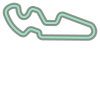

In [12]:
# Make a poly out of our center line, expanding its dimensions to have outer and inner boundaries
ls_center = LineString(waypoints)
poly = ls_center.buffer(1.07/2.0)
print("Center Closed: ", ls_center.is_ring)
print("Center Length: ", ls_center.length)
print("Center Bounds: ", ls_center.bounds)
exterior_coords = poly.exterior.coords[:]
interior_coords = []
for interior in poly.interiors:
    interior_coords += interior.coords[:]

ls_outer = LineString(exterior_coords)
ls_inner = LineString(interior_coords)
#Generate final waypoint list as [center_x, center_y, inner_x, inner_y, outer_x, outer_y]
all_waypoints = list()
for i in range(len(ls_center.coords)):
    distance = i / len(ls_center.coords)
    center_point = ls_center.coords[i]
    outer_point = ls_outer.interpolate(distance, normalized=True)
    inner_point = ls_inner.interpolate(distance, normalized=True)
    all_waypoints.append(list(sum((center_point, inner_point.coords[0], outer_point.coords[0]), ())))

poly

In [13]:
wp = np.array(all_waypoints)
center_line = wp[:,0:2]
inner_border = wp[:,2:4]
outer_border = wp[:,4:6]

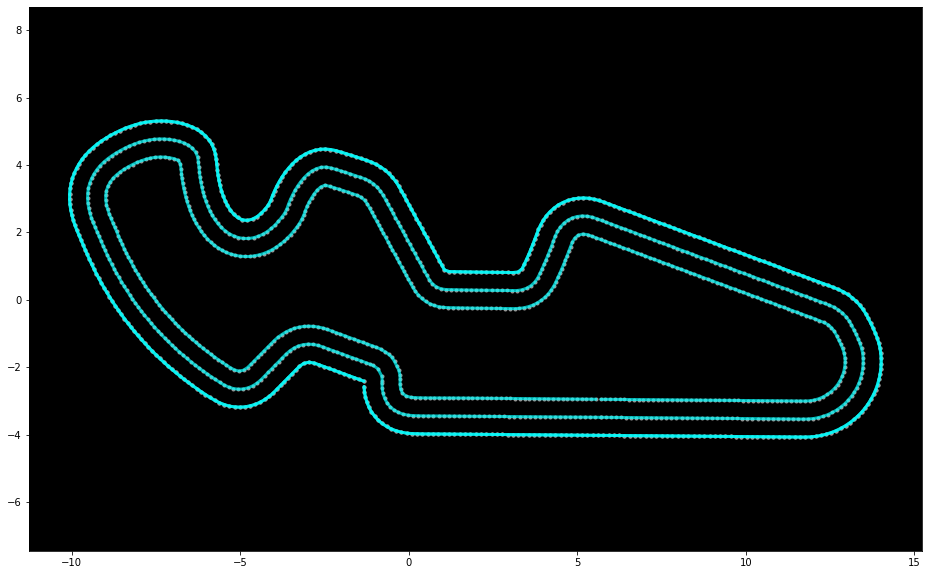

In [14]:
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border)

In [27]:
fname = "../tracks/%s.npy"% track_name
np.save(fname, all_waypoints)

NameError: name 'track_name' is not defined